# Figure R9 (results), S10, S11 (supplementary materials)
### Visualize seasonal jet of Atlantic water

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.patches as patches
import cmocean
import matplotlib
from matplotlib.colors import ListedColormap
from math import sin, cos, sqrt, atan2, radians
import xarray as xr
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from constants import imin, imax, jmin, jmax, \
                      land_color, land_edge, path_figure

%matplotlib inline

#### Parameters:

In [2]:
# Resolution of grid cells to show in figure:
grid_reso  = 10

# Colors:
color_GS = '#003856';
color_BB = '#0369a0';
color_BI = '#81b4cf';

# transect coordinates:
BB_coords = (1470,1471,515,670) # Baffin Bay
DS_coords = (1290,1291,502,630) # Davis Strait (jet)

# Names for labels
month_list = ['Jan.','Feb.','Mar.','Apr.','May','June','July', 'Aug.', 'Sep.','Oct.','Nov.', 'Dec.']
full_month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', \
                   'August', 'September', 'October', 'November', 'December']

In [3]:
cmap1 = cmocean.cm.balance
cmap1.set_bad(land_color, 1)   

#### Load files:

In [4]:
# And the Pb model configuration ANHA12 mask:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mfile['nav_lon'].values
mesh_lat     = mfile['nav_lat'].values
mask         = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values

# ANHA12 mesh file:
mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_hdept  = mesh['hdept'].values[0,:,:]
mesh_hdepw  = mesh['hdepw'].values[0,:,:]
mesh_mbathy = mesh['mbathy'].values[0,:,:]
mesh_gdepw  = mesh['gdepw_1d'].values[0,:]

In [5]:
# transect coordinates
DS_lons  = mesh_lon[DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][0,:]
DS_lats  = mesh_lat[DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][0,:]
DS_deps  = bathy_masked[:,DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][:,0,:]

#### Functions

In [6]:
def plot_layer(ax, variable, layer, vmin=0, vmax=30, month='', cmap=cmocean.cm.balance):
    # Function plots the variable at specified layer number on the axis
    cmap2 = cmap
    cmap2.set_bad(land_color, 1)   

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax])
    
    CB = proj1.pcolormesh(x, y, variable[layer,:,:]*1e12, cmap=cmap2, vmin=vmin, vmax=vmax, ax=ax) 
    ax.set_facecolor(land_color)

    proj1.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], \
               cmap=matplotlib.colors.ListedColormap([land_color]), zorder=1, ax=ax)

    ax.set_title(f'{month}', fontsize=7)
    return CB

In [7]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [8]:
def get_boundary_depths(bdy_distance, bdy_ind, cell=0):
    # Function to calculate the depths of the cells at the boundary locations
    
    model_depths    = np.zeros((len(mesh_depth), len(bdy_distance)))
    for n in range(0,len(bdy_distance)):         
        mesh_depth_adjusted = np.copy(mesh_gdepw)
        if (bdy_ind[1]-bdy_ind[0]) < (bdy_ind[3]-bdy_ind[2]): # depending on orientation of boundary
            bathy_ind           = mesh_mbathy[bdy_ind[0]+cell, bdy_ind[2]+n]
            mesh_depth_adjusted[0:int(bathy_ind)+1]  = mesh_hdept[bdy_ind[0]+cell, bdy_ind[2]+n]
        else:
            bathy_ind           = mesh_mbathy[bdy_ind[0]+n, bdy_ind[2]+cell]
            mesh_depth_adjusted[0:int(bathy_ind)+1]  = mesh_hdept[bdy_ind[0]+n, bdy_ind[2]+cell]

        model_depths[:,n]    = mesh_depth_adjusted
    
    return model_depths

In [9]:
def land_patch(distances, coordi, coordj):
    # Function creates a patch to mask land in figure
    topo = []
    for d, distance in enumerate(distances[0:-1]):
        rect = Rectangle((distance, mesh_hdepw[coordi,coordj+d]), distances[d+1]-distance, 5000)
        topo.append(rect)

    pc = PatchCollection(topo, facecolors=land_color, edgecolors=land_color, alpha=1)
    return pc

#### Calculations

In [10]:
# Calculate the distance of each grid point relative to the southwest corner of the transect and find cell depths
DS_distance     = calc_distance(DS_lats, DS_lons) 
DS_model_depths = get_boundary_depths(DS_distance, DS_coords,  cell=0)

In [11]:
# Load simulated dissolved Pb concentration climatology for the reference and Labrador Atlantic experiments:
ds_ref  = xr.open_dataset(f'/data/brogalla/run_storage/Pb-reference-202312/climatology.nc')
ds_lab  = xr.open_dataset(f'/data/brogalla/run_storage/Pb-Labrador-202312/climatology.nc')
dPb_ref = ds_ref['dissolpb'].values[:,0,:,:,:]
dPb_LS  = ds_lab['dissolpb'].values[:,0,:,:,:]

In [12]:
# Calculate delta_dissolvedPb, the difference between the two experiments (mean field and monthly climatology)
delta_dPb         = (dPb_LS - dPb_ref).mean(axis=0) 
delta_dPb_monthly = (dPb_LS - dPb_ref)

#### Figure:

In [23]:
def setup_figure(month_start, month_end, layer=0):
    fig, ax = plt.subplots(2,4, figsize=(4.5*2, 3.74*1.5), dpi=300, gridspec_kw={'height_ratios':[2,1]})

    for axis in ax[0,:].ravel():
        proj1=Basemap(projection='eqdc',lat_0 = 69, lon_0 = -58, resolution='i', width=1.3e6, height=2.1e6, ax=axis)

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax])
    
    # ---- seasonal jet ---------------
    for n, mth in enumerate(range(month_start,month_end+1)):
        CB1 = proj1.pcolormesh(x, y, ((dPb_LS[mth-1,layer,:,:]-dPb_ref[mth-1,layer,:,:]) - \
                              (dPb_LS[:,layer,:,:]-dPb_ref[:,layer,:,:]).mean(axis=0))*1e12, \
                              cmap=cmap1, vmin=-1, vmax=1, ax=ax[0,n]) 
        proj1.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], \
                           cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2, ax=ax[0,n])
        ax[0,n].set_title(f'{full_month_list[mth-1]}', fontsize=7)
        ax[0,n].plot(x[DS_coords[0]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin], 
                     y[DS_coords[0]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin], 'w', linestyle=(0, (3, 1)), lw=1.6, zorder=4)
        proj1.drawcoastlines(color=land_edge, linewidth=1.0, zorder=2, ax=ax[0,n]);
        proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=3, ax=ax[0,n]);
        ax[0,n].set_facecolor(land_color)

    # --- cross sections -------------
    # Cross-section
    for n, mth in enumerate(range(month_start,month_end+1)):        
        ax[1,n].set_xlabel('Distance [km]', fontsize=7)
        ax[1,n].invert_yaxis()
        ax[1,n].tick_params(axis='both', which='major', labelsize=6)
        ax[1,n].set_ylim(700,0)
        ax[1,n].set_xlim(0,520)

    ax[1,0].set_ylabel('Depth [m]', fontsize=7)

    # Color bar: --------------------------------------------------------------------------------
    cbaxes = fig.add_axes([0.03, 0.44, 0.02, 0.32]);
    CBar   = plt.colorbar(CB1, cax=cbaxes, extend='max'); 
    CBar.set_label(r"Seasonality of $\Delta$ Dissolved Pb [pM]"+'\n relative to climatology', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=7)

    fig.text(0.125, 0.89, 'a)', fontsize=10, weight='bold');
    fig.text(0.33, 0.89, 'b)', fontsize=10, weight='bold');
    fig.text(0.53, 0.89, 'c)', fontsize=10, weight='bold');
    fig.text(0.73, 0.89, 'd)', fontsize=10, weight='bold');

    fig.text(0.125, 0.37, 'e)', fontsize=10, weight='bold');
    fig.text(0.33, 0.37, 'f)', fontsize=10, weight='bold');
    fig.text(0.53, 0.37, 'g)', fontsize=10, weight='bold');
    fig.text(0.73, 0.37, 'h)', fontsize=10, weight='bold');
    
    return fig, ax

In [24]:
def plot_delta_dPb(month_start, month_end, layer=27, fig_name=''):
    # Function to create the 8-panel figure with a-d, displaying each month from month_start up to and 
    # including month_end at depth level specified by layer

    fig, ax = setup_figure(month_start, month_end, layer=layer)

    xx, zz = np.meshgrid(DS_distance, mesh_gdepw)
    for n, mth in enumerate(range(month_start,month_end+1)):
        ref = dPb_ref[mth-1,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin][:,0,:]
        LS  = dPb_LS[mth-1,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin][:,0,:]
        ref_mean = dPb_ref[:,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin].mean(axis=0)[:,0,:]
        LS_mean  = dPb_LS[:,:,DS_coords[0]-imin:DS_coords[1]-imin,DS_coords[2]-jmin:DS_coords[3]-jmin].mean(axis=0)[:,0,:]
        ax[0,n].set_title(f'{full_month_list[mth-1]}', fontsize=7)
        ax[1,n].set_title(f'{full_month_list[mth-1]}', fontsize=7)

        CB1 = ax[1,n].pcolormesh(xx, zz, ((LS-ref)-(LS_mean-ref_mean))*1e12, vmin=-1, vmax=1, cmap=cmap1)
        DS_patch = land_patch(DS_distance, DS_coords[0], DS_coords[2])
        ax[1,n].add_collection(DS_patch)

        if fig_name:
            fig.savefig(f'{fig_name}', dpi=300, bbox_inches='tight')
    
    return

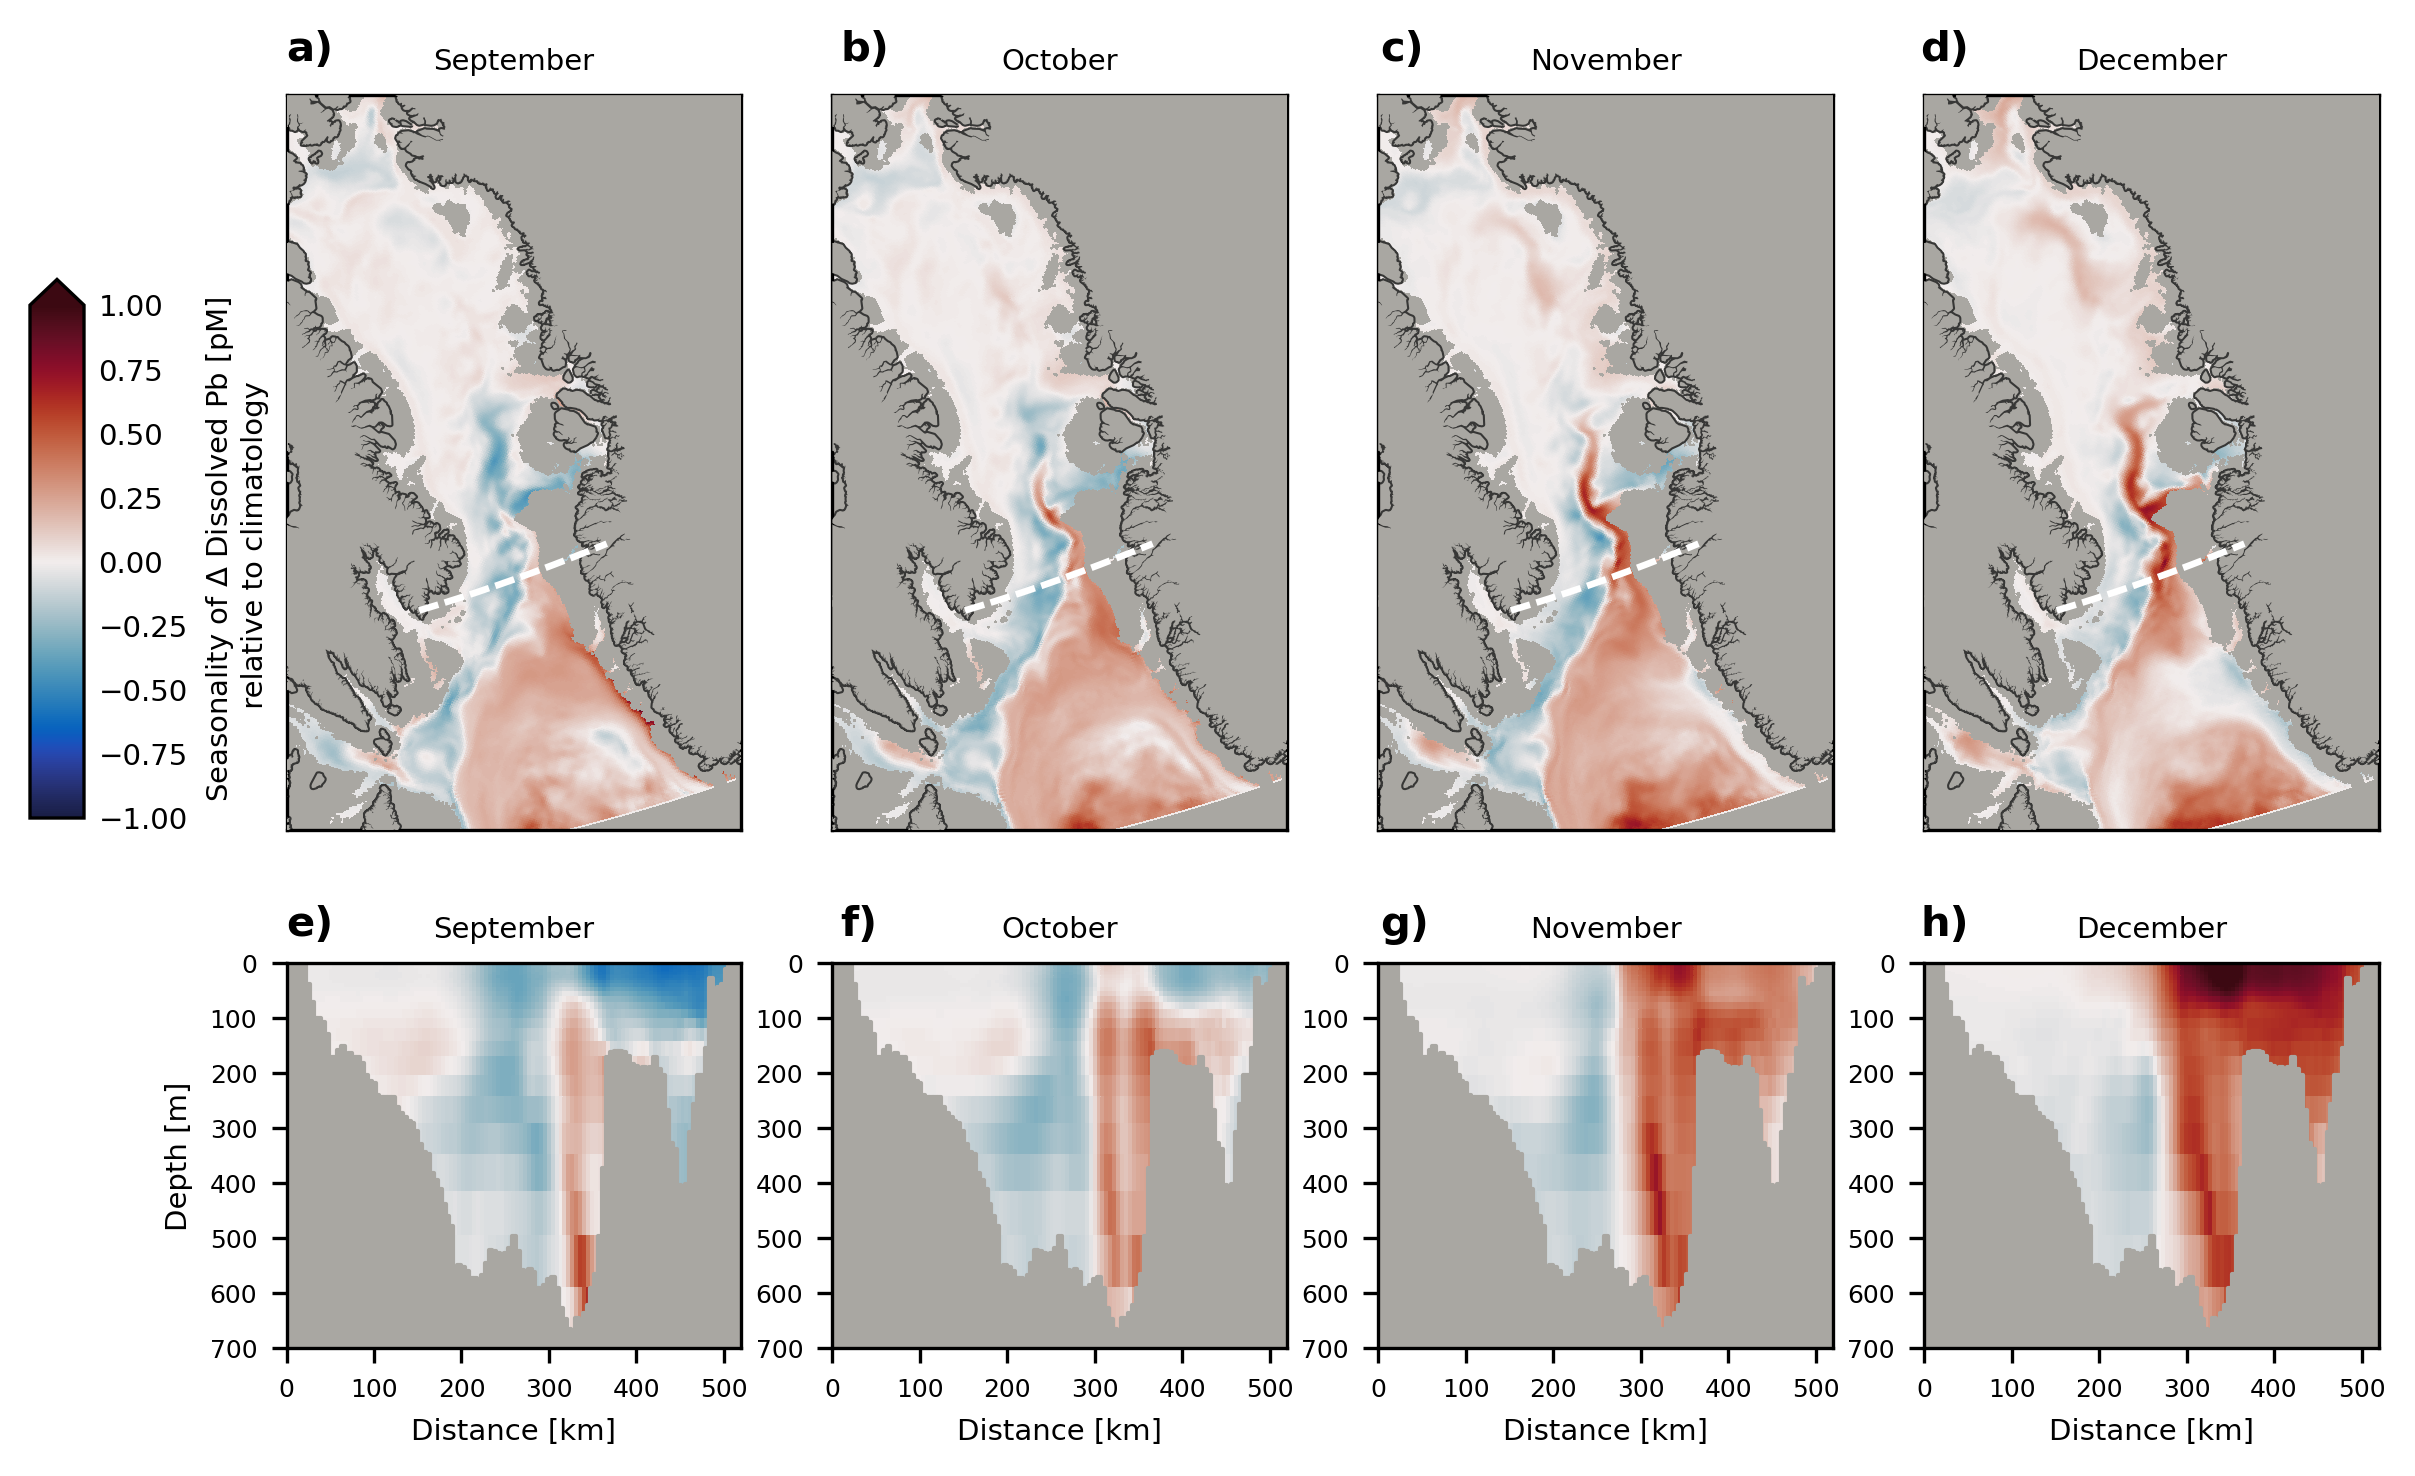

In [28]:
plot_delta_dPb(9, 12, layer=27, fig_name=f'{path_figure}R9-jet.jpg')

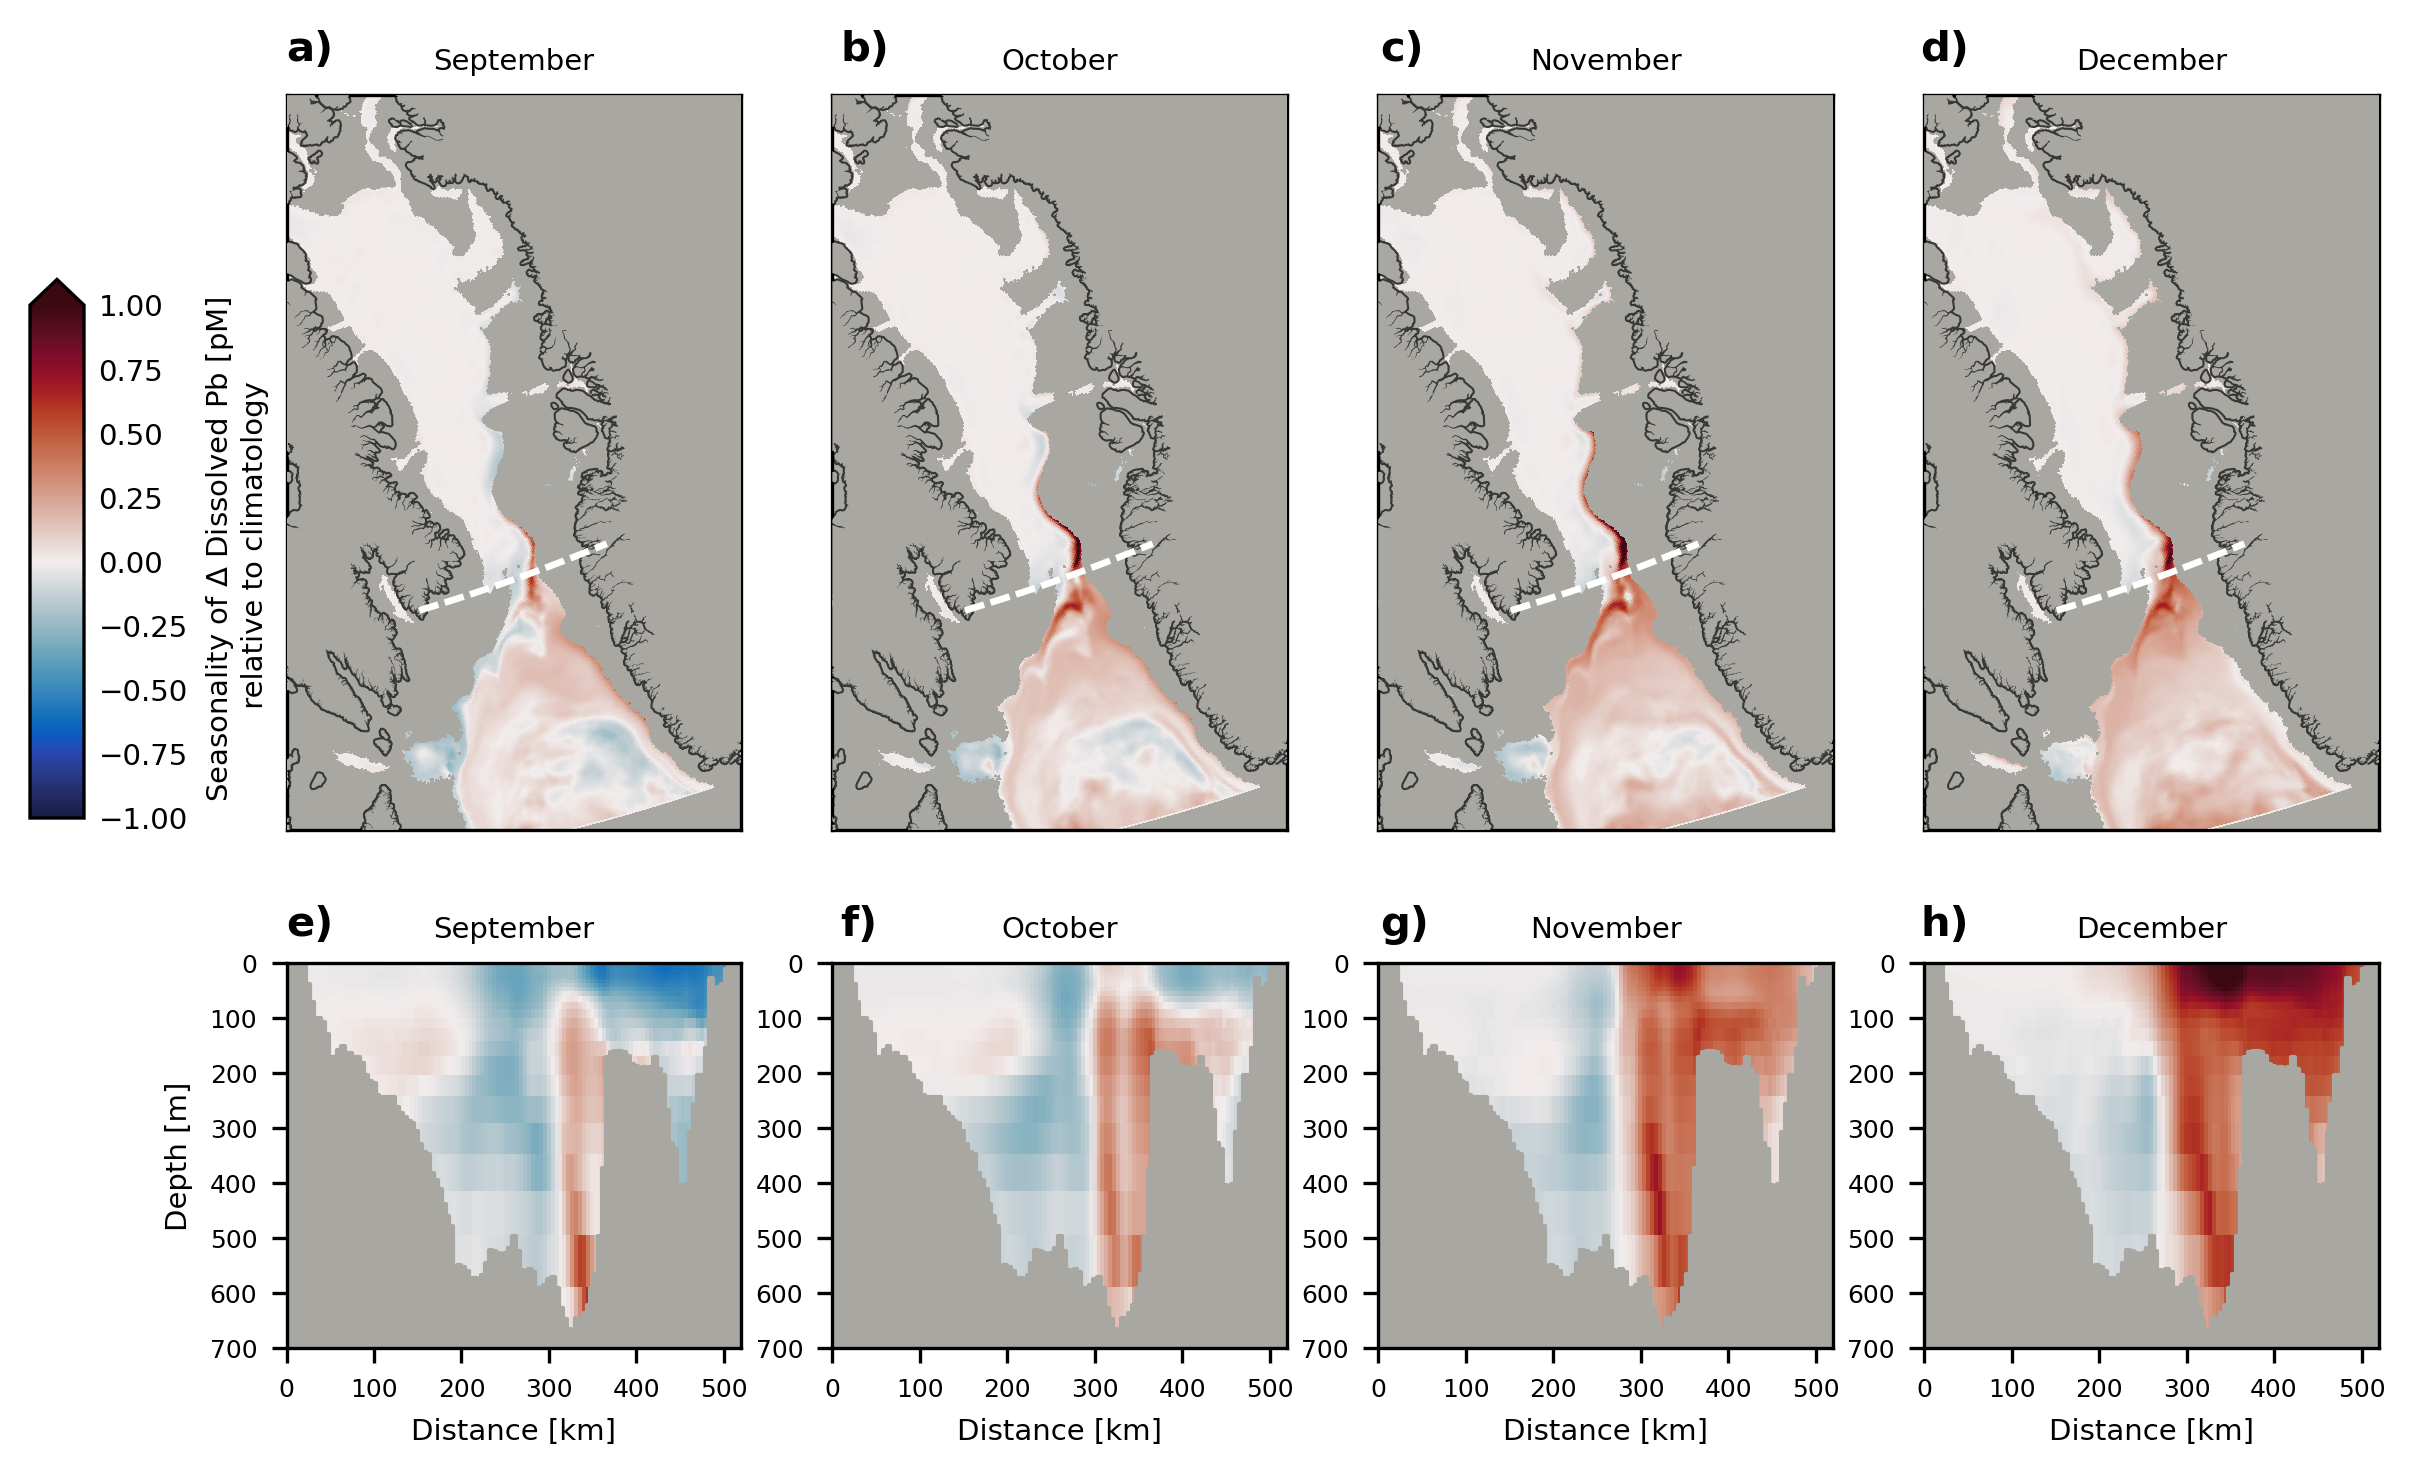

In [29]:
plot_delta_dPb(9, 12, layer=31, fig_name=f'{path_figure}S10.jpg')

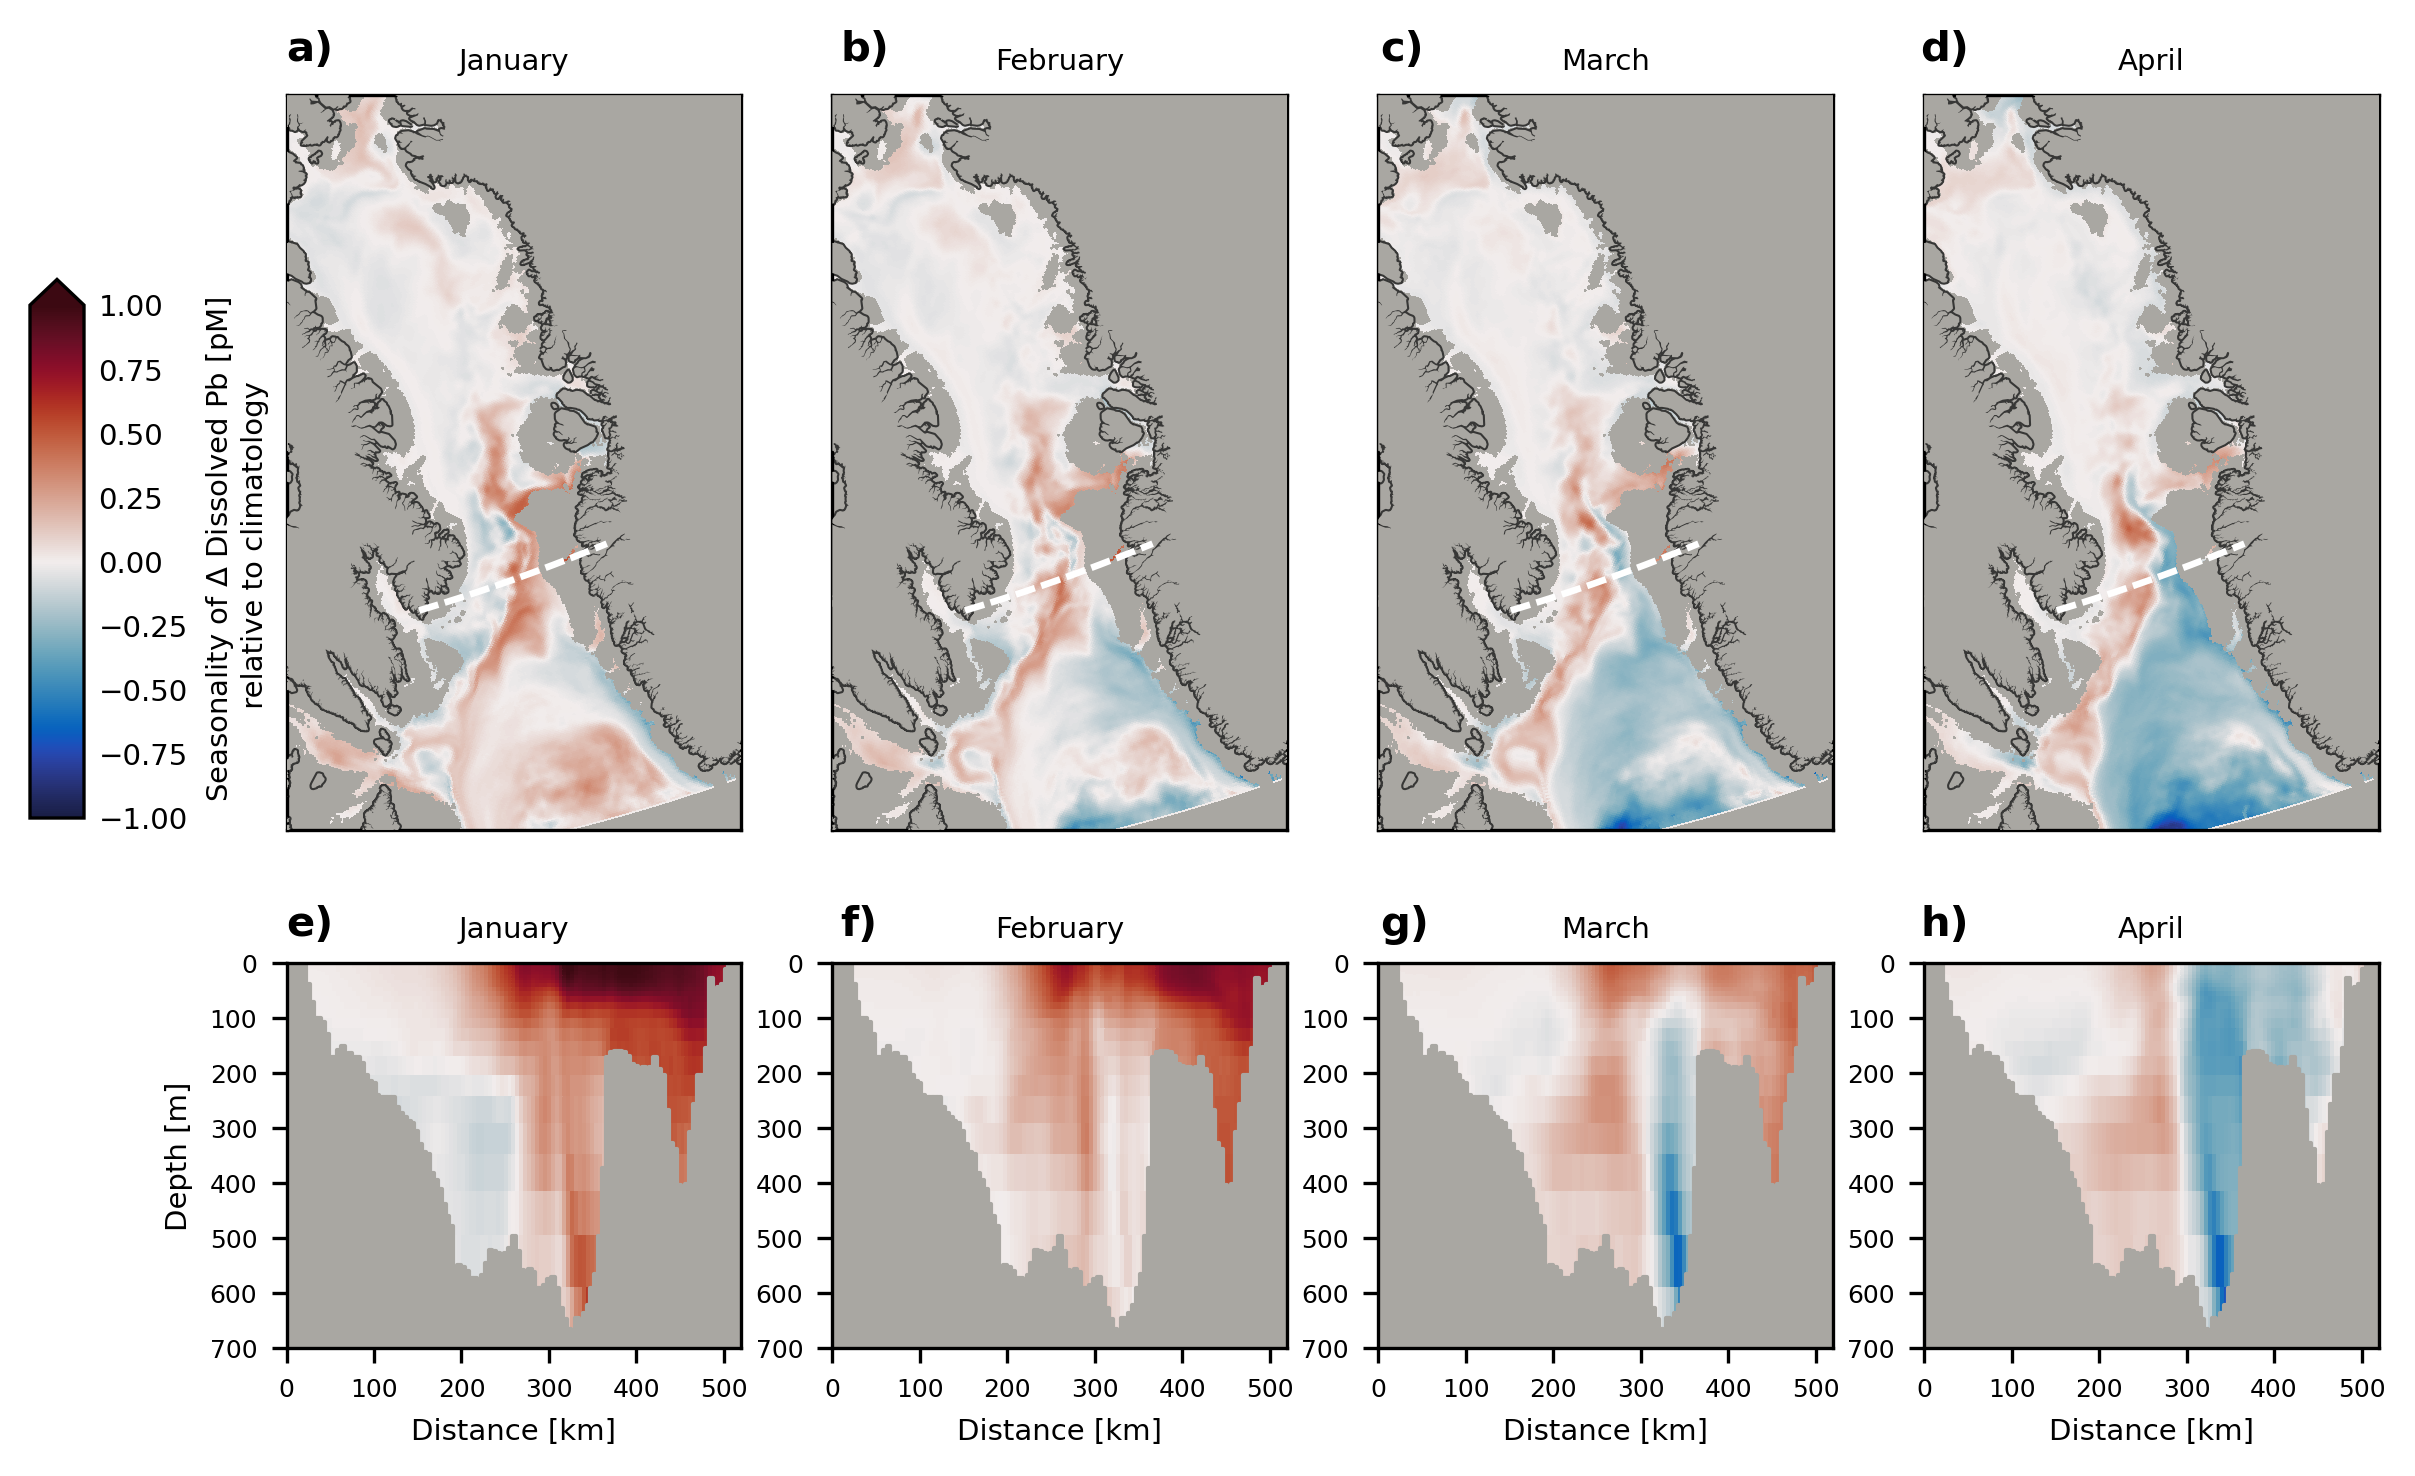

In [30]:
plot_delta_dPb(1, 4, layer=27, fig_name=f'{path_figure}S11.jpg')